## Correlating NAO and Overturning anomalies

In this notebook, we compute correlations between NAO and overturning anomalies. Since overturning strength could evolve in some definite time due to atmospheric forcing, we consider time-lagged correlation. Moreoever, oceans may retain memomry for some time. Thus, it might be more approapriate to use intergral definitions.

Assuming that surface heat flux anomalies, which are strongly correlated to NAO phases, affect overturning with some time lag, we could write the following


$\psi(y,t+\tau) \propto \int_{t_0}^{t}\text{NAO}dt$


In [1]:
# Load libraries

import numpy as np
import math
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as mtick
import dask
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler, ProgressBar, visualize

In [2]:
#from dask.distributed import Client, LocalCluster

#cluster = LocalCluster()
#client = Client()

#client

In [4]:
ppdir = "/home/users/hkhatri/DePreSys4_Data/Data_Anomaly_Compute/NAO/"

ds_NAO = xr.open_dataset(ppdir + "NAO_SLP_Anomaly.nc")

print(ds_NAO)

<xarray.Dataset>
Dimensions:     (start_year: 57, r: 10, time: 125)
Coordinates:
  * start_year  (start_year) int64 1960 1961 1962 1963 ... 2013 2014 2015 2016
Dimensions without coordinates: r, time
Data variables:
    NAO         (start_year, r, time) float64 ...
    P_south     (start_year, r, time) float64 ...
    P_north     (start_year, r, time) float64 ...
    time_val    (start_year, time) object ...


In [4]:
ppdir="/home/users/hkhatri/DePreSys4_Data/Data_Consolidated/"

# variable list to keep in the dataset
var_list = ['hfbasin_atlantic', 'sltbasin_atlantic', 'zomsfatl']

ds = xr.open_dataset(ppdir+"Overturning_z.nc", decode_times=False, chunks={'r':1, 'y':1})
ds = ds.get(var_list)
ds = xr.decode_cf(ds)

print(ds)

<xarray.Dataset>
Dimensions:            (start_year: 57, r: 10, time_counter: 125, y: 451, x: 1, depthw: 75)
Coordinates:
  * depthw             (depthw) float32 0.0 1.024 2.103 ... 5.596e+03 5.8e+03
    nav_lat            (y, x) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    nav_lon            (y, x) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    time_centered      (start_year, time_counter) object dask.array<chunksize=(57, 125), meta=np.ndarray>
  * time_counter       (time_counter) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
  * start_year         (start_year) int64 1960 1961 1962 1963 ... 2014 2015 2016
Dimensions without coordinates: r, y, x
Data variables:
    hfbasin_atlantic   (start_year, r, time_counter, y, x) float32 dask.array<chunksize=(57, 1, 125, 1, 1), meta=np.ndarray>
    sltbasin_atlantic  (start_year, r, time_counter, y, x) float32 dask.array<chunksize=(57, 1, 125, 1, 1), meta=np.ndarray>
    zomsfatl           (start_year, r, time_counter, depthw, 

In [5]:
ppdir_drift="/home/users/hkhatri/DePreSys4_Data/Data_Drift_Removal/Drift_1970_2016_Method_DCPP/"

ds_drift = []

for lead_year in range(0, 11):
    
    d = xr.open_dataset(ppdir_drift + "diaptr/" + "Drift_diaptr_Lead_Year_" + 
                        str(lead_year + 1) + ".nc", decode_times= False)
    d = d.assign(time_counter = np.arange(lead_year*12, 12*lead_year + np.minimum(12, len(d['time_counter'])), 1))
    
    ds_drift.append(d)
    
ds_drift = xr.concat(ds_drift, dim='time_counter')

ds_drift = ds_drift.get(var_list)

ds_drift = ds_drift.chunk({'r':1, 'y':1})

print(ds_drift)

<xarray.Dataset>
Dimensions:            (r: 10, time_counter: 125, y: 451, x: 1, depthw: 75)
Coordinates:
  * depthw             (depthw) float32 0.0 1.024 2.103 ... 5.596e+03 5.8e+03
    nav_lat            (y, x) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    nav_lon            (y, x) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
  * time_counter       (time_counter) int64 0 1 2 3 4 5 ... 120 121 122 123 124
    time_centered      (time_counter) float64 dask.array<chunksize=(125,), meta=np.ndarray>
    start_year         (time_counter) int64 dask.array<chunksize=(125,), meta=np.ndarray>
Dimensions without coordinates: r, y, x
Data variables:
    hfbasin_atlantic   (r, time_counter, y, x) float32 dask.array<chunksize=(1, 125, 1, 1), meta=np.ndarray>
    sltbasin_atlantic  (r, time_counter, y, x) float32 dask.array<chunksize=(1, 125, 1, 1), meta=np.ndarray>
    zomsfatl           (r, time_counter, depthw, y, x) float32 dask.array<chunksize=(1, 125, 75, 1, 1), meta=np.

In [6]:
ds = ds.drop('time_counter') 
ds_drift = ds_drift.drop(['time_counter','start_year'])

ds_anom = ds - ds_drift

psi_anom = ds.zomsfatl.mean(['x']).max(dim='depthw') - ds_drift.zomsfatl.mean(['x']).max(dim='depthw')

ds_anom['psi_anom'] = psi_anom #anomaly in psi max 

print(ds_anom)

<xarray.Dataset>
Dimensions:            (depthw: 75, y: 451, x: 1, start_year: 57, r: 10, time_counter: 125)
Coordinates:
  * depthw             (depthw) float32 0.0 1.024 2.103 ... 5.596e+03 5.8e+03
    nav_lat            (y, x) float32 3.997 4.246 4.495 ... 79.85 79.92 79.99
    nav_lon            (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  * start_year         (start_year) int64 1960 1961 1962 1963 ... 2014 2015 2016
Dimensions without coordinates: y, x, r, time_counter
Data variables:
    hfbasin_atlantic   (start_year, r, time_counter, y, x) float32 dask.array<chunksize=(57, 1, 125, 1, 1), meta=np.ndarray>
    sltbasin_atlantic  (start_year, r, time_counter, y, x) float32 dask.array<chunksize=(57, 1, 125, 1, 1), meta=np.ndarray>
    zomsfatl           (start_year, r, time_counter, depthw, y, x) float32 dask.array<chunksize=(57, 1, 125, 75, 1, 1), meta=np.ndarray>
    psi_anom           (start_year, r, time_counter, y) float32 dask.array<chunksize=(57, 1, 125, 1), meta

### Start with NAO+ in first DJF

If we treat all hindcasts the same, we effectively have 10*57 = 570 ensemble members. In the figure below, we have plotted NAO indices for every month for each ensemble member. It is clear that we observe extreme NAO patterns in winter months when the jet stream is the strongest.

Text(0.5, 0, 'Month')

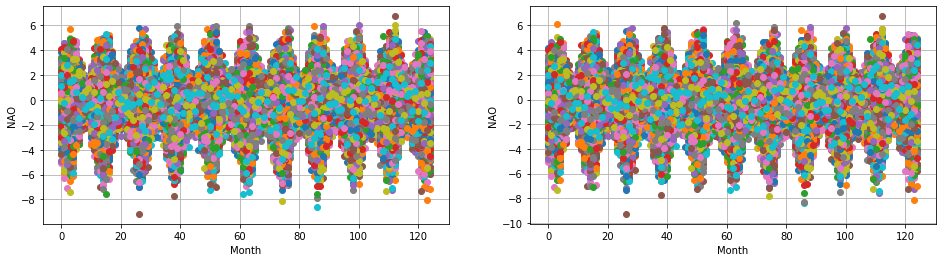

In [7]:
NAO_anom = ds_NAO['NAO'] - ds_NAO['NAO'].mean('start_year') # this is rough calculation (don't use this for final analysis)
# removing mean does not seem to make any difference. So let's stick with NAO, which we computed using sea-level pressure anomalies.

fig = plt.figure(figsize=[16,4])

plt.subplot(1,2,1)
for year in range(0,len(ds_NAO['start_year'])):
    
    for r in range(0,10):
        
        plt.plot(ds_NAO['NAO'].isel(start_year=year, r=r),'o')
        
plt.grid('on')
plt.ylabel('NAO')
plt.xlabel('Month')
        
        
plt.subplot(1,2,2)
for year in range(0,len(ds_NAO['start_year'])):
    
    for r in range(0,10):
        
        plt.plot(NAO_anom.isel(start_year=year, r=r),'o')
        
plt.grid('on')
plt.ylabel('NAO')
plt.xlabel('Month')

#### Seasonal dependence

At first, instead of looking at all members, we look at runs that have strong positive (or negative) NAO phase in the first DJF. We set cutoff for NAO+ indices to be greater than 2. we then examine how the system evolves over time and how surface properties change. For this, we first compute seasonal-mean NAO indices and isolate members having NAO > 2. in first DJF.

It is interesting to see that, if we look at members that have strong NAO+ phase in the first DJF, they tend not to have verty strong NAO phase in other seasons.

In [7]:
NAO_season = ds_NAO['NAO'].copy()
tim = ds_NAO['time_val'].isel(start_year=0).drop('start_year')
NAO_season = NAO_season.assign_coords(time=tim)

NAO_season = NAO_season.isel(time=slice(1,len(NAO_season.time)-1)) # get rid of first Nov and last Mar for better seasonal avg

with ProgressBar():
    NAO_season = NAO_season.resample(time='QS-DEC').mean('time').compute()

Text(0.5, 0, 'Season from start')

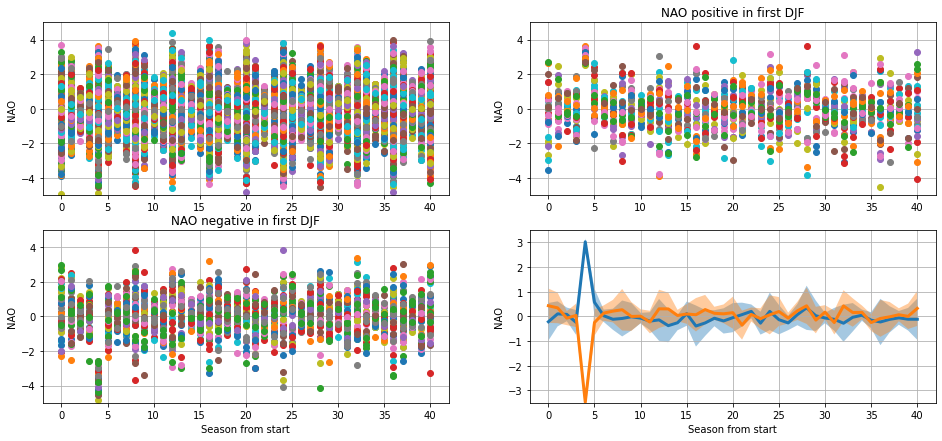

In [8]:
NAO_cut = 2.5
tim_ind = 4

fig = plt.figure(figsize=[16,7])


plt.subplot(2,2,2)
for year in range(0,len(ds_NAO['start_year'])):
    
    for r in range(0,10):
        
        plt.plot(NAO_season.isel(start_year=year, r=r).where(NAO_season.isel(start_year=year, r=r,time=tim_ind) >= NAO_cut), 'o')
        
plt.grid('on')
plt.ylim([-5, 5])
plt.ylabel('NAO')
plt.title('NAO positive in first DJF')

plt.subplot(2,2,3)
for year in range(0,len(ds_NAO['start_year'])):
    
    for r in range(0,10):
        
        plt.plot(NAO_season.isel(start_year=year, r=r).where(NAO_season.isel(start_year=year, r=r,time=tim_ind) <= -NAO_cut),'o')
        
plt.grid('on')
plt.ylim([-5, 5])
plt.xlabel('Season from start')
plt.ylabel('NAO')
plt.title('NAO negative in first DJF')

tmp = NAO_season.isel(time=0)

plt.subplot(2,2,1)
for year in range(0,len(ds_NAO['start_year'])):
    
    for r in range(0,10):
        
        plt.plot(NAO_season.isel(start_year=year, r=r),'o')
        
plt.grid('on')
plt.ylim([-5, 5])
plt.ylabel('NAO')

tmp1 = NAO_season.where(NAO_season.isel(time=tim_ind) >= NAO_cut).mean(['start_year','r'])
tmp1_std = NAO_season.where(NAO_season.isel(time=tim_ind) >= NAO_cut).std(['start_year','r'])
tmp2 = NAO_season.where(NAO_season.isel(time=tim_ind) <= -NAO_cut).mean(['start_year','r'])
tmp2_std = NAO_season.where(NAO_season.isel(time=tim_ind) <= -NAO_cut).std(['start_year','r'])

plt.subplot(2,2,4)
plt.plot(tmp1, lw=3)
plt.fill_between(range(0,41), tmp1 - 0.5*tmp1_std, tmp1 + 0.5*tmp1_std, alpha=0.4)
plt.plot(tmp2, lw=3)
plt.fill_between(range(0,41), tmp2 - 0.5*tmp2_std, tmp2 + 0.5*tmp2_std, alpha=0.4)
plt.grid('on')
plt.ylim([-3.5, 3.5])
plt.ylabel('NAO')
plt.xlabel('Season from start')

In [10]:
# check .where is performing as expected

tmp = NAO_season.where(NAO_season.isel(time=tim_ind) >= NAO_cut)

# start_year = 43, 50 have NAO > 2.5
print(tmp.isel(time=0,r=1))

# NAO values are retained for all seasons for the aove start years
print(tmp.isel(r=1,start_year=43))

<xarray.DataArray 'NAO' (start_year: 57)>
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan, -0.58687797,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,  2.64711829,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
        0.79226262,         nan])
Coordinates:
    time        object 1960-12-01 00:00:00
  * start_year  (start_year) int64 1960 1961 1962 1963 ... 2013 2014 2015 20

In [125]:
count_NAOp = xr.where(NAO_season.isel(time=tim_ind) >= NAO_cut, 1, 0)
count_NAOn = xr.where(NAO_season.isel(time=tim_ind) <= -NAO_cut, 1, 0)

# count NAO extreme cases
print(count_NAOp.sum(), count_NAOn.sum())

<xarray.DataArray 'NAO' ()>
array(30)
Coordinates:
    time     object 1961-12-01 00:00:00 <xarray.DataArray 'NAO' ()>
array(45)
Coordinates:
    time     object 1961-12-01 00:00:00


#### Overturning Anomalies

We can follow the same for overturning and look at time series of overturning anomalies that had strong +ve/-ve NAO phases in the first DJF.

In [13]:
#psi_anom = ds.zomsfatl.mean(['x']).max(dim='depthw') - ds_drift.zomsfatl.mean(['x']).max(dim='depthw')

psi_max= ds_anom['psi_anom'].rename({'time_counter':'time'})
psi_max = psi_max.assign_coords(y=ds_anom.nav_lat.isel(x=0), time=tim)
#psi_max = psi_max.sel(y=slice(20.,65.))
psi_max = psi_max.sel(y= [30., 35., 40., 45., 50., 55., 60.], method="nearest")
#psi_max = psi_max.isel(time=slice(1,len(psi_max['time'])-1))

In [14]:
with Profiler() as prof, ResourceProfiler() as rprof, CacheProfiler() as cprof:
    %time psi_max = psi_max.compute()

CPU times: user 2.19 s, sys: 13.1 s, total: 15.3 s
Wall time: 14.4 s


In [15]:
visualize([prof, rprof, cprof], filename='profile_20_65.html')

Column(id='1240', ...)

In [16]:
%time psi_season = psi_max.isel(time=slice(1,len(psi_max['time'])-1)).resample(time='QS-DEC').mean('time').compute()

CPU times: user 27.4 ms, sys: 7.81 ms, total: 35.2 ms
Wall time: 33.1 ms


Text(0.5, 1.0, 'NAO negative DJF')

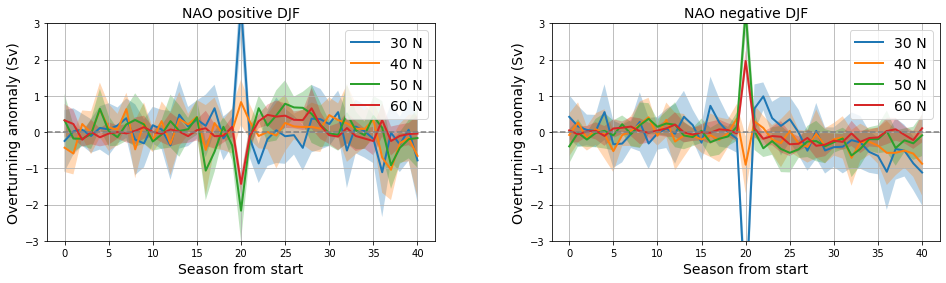

In [77]:
#tim_ind =4

import math

tmp1 = (psi_season.where(NAO_season.isel(time=tim_ind+16) >= NAO_cut).mean(['start_year','r']))

tmp2 = (psi_season.where(NAO_season.isel(time=tim_ind+16) <= -NAO_cut).mean(['start_year','r']))

grid1 = plt.GridSpec(1, 2, wspace=0.3, hspace=0.3)
fig = plt.figure(figsize=[16,4])

N = count_NAOp.sum().values # 7 days decorrelation time
ci = 1.96 # coefficiet for large N and 95% confidence interval
std_err = (ci/np.sqrt(np.ceil(N)))

ax = fig.add_subplot(grid1[0, 0])
for y in range(0,len(tmp1.y), 2):
    tmp1_std = ((psi_season.sel(y= tmp1['y'].values[y], method="nearest"))
                .where(NAO_season.isel(time=tim_ind) >= NAO_cut).std(['start_year','r']))
    
    ax.plot(tmp1.isel(y=y), lw=2., label= str(math.floor(tmp1['y'].values[y])) + ' N')
    ax.fill_between(range(0,41), (tmp1.isel(y=y) - std_err*tmp1_std), 
                    (tmp1.isel(y=y) + std_err*tmp1_std), alpha=0.3)

ax.axhline(y=0, color='grey', ls='--')
ax.legend(fontsize=14)
ax.grid('on')
ax.set_ylim([-3.0, 3.0])
ax.set_ylabel('Overturning anomaly (Sv)', fontsize=14)
ax.set_xlabel('Season from start', fontsize=14)
ax.set_title('NAO positive DJF', fontsize=14)

N = count_NAOn.sum().values # 7 days decorrelation time
ci = 1.96 # coefficiet for large N and 95% confidence interval
std_err = (ci/np.sqrt(np.ceil(N)))

ax = fig.add_subplot(grid1[0, 1])
for y in range(0,len(tmp1.y), 2):
    tmp2_std = ((psi_season.sel(y= tmp1['y'].values[y], method="nearest"))
                .where(NAO_season.isel(time=tim_ind) <= -NAO_cut).std(['start_year','r']))
    
    ax.plot(tmp2.isel(y=y), lw=2., label=str(math.floor(tmp1['y'].values[y])) + ' N')
    ax.fill_between(range(0,41), (tmp2.isel(y=y) - std_err*tmp2_std), 
                    (tmp2.isel(y=y) + std_err*tmp2_std), alpha=0.3)

ax.axhline(y=0, color='grey', ls='--')
ax.legend(fontsize=14)
ax.grid('on')
ax.set_ylim([-3.0, 3.0])
ax.set_ylabel('Overturning anomaly (Sv)', fontsize=14)
ax.set_xlabel('Season from start', fontsize=14)
ax.set_title('NAO negative DJF', fontsize=14)

In [70]:
%%time
psiz_NAOp = (ds_anom['zomsfatl'].where(NAO_season.isel(time=tim_ind) 
                                        >= NAO_cut).mean(['start_year','r', 'x'])).compute()

psiz_NAOn = (ds_anom['zomsfatl'].where(NAO_season.isel(time=tim_ind) 
                                        <= -NAO_cut).mean(['start_year','r', 'x'])).compute()

CPU times: user 96.9 ms, sys: 2.95 ms, total: 99.8 ms
Wall time: 97.1 ms


In [71]:
%%time 

psiz_NAOp_season = psiz_NAOp.drop('time').rename({'time_counter':'time'})
psiz_NAOp_season = psiz_NAOp_season.assign_coords(y=ds_anom.nav_lat.isel(x=0), time=tim)

psiz_NAOp_season = psiz_NAOp_season.isel(time=slice(1,len(psiz_NAOp_season['time'])-1)).resample(time='QS-DEC').mean('time').compute()

psiz_NAOn_season = psiz_NAOn.drop('time').rename({'time_counter':'time'})
psiz_NAOn_season = psiz_NAOn_season.assign_coords(y=ds_anom.nav_lat.isel(x=0), time=tim)

psiz_NAOn_season = psiz_NAOn_season.isel(time=slice(1,len(psiz_NAOn_season['time'])-1)).resample(time='QS-DEC').mean('time').compute()

CPU times: user 2min 21s, sys: 14min 24s, total: 16min 45s
Wall time: 15min 57s


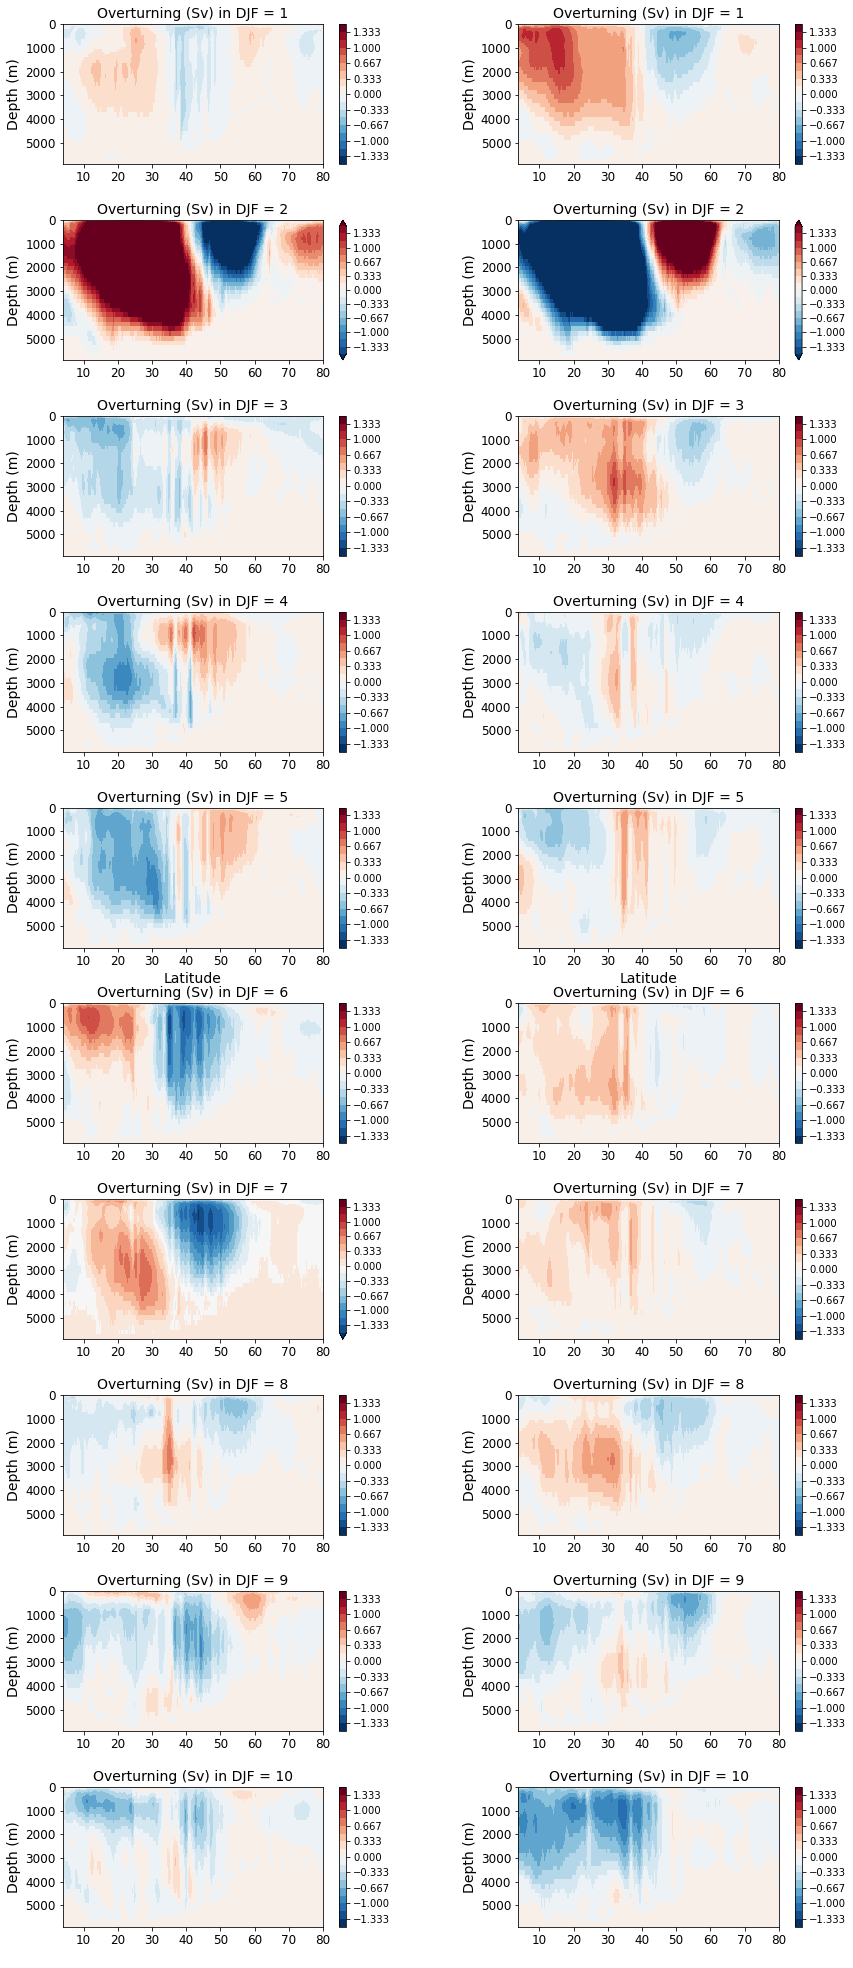

In [76]:
grid1 = plt.GridSpec(10, 2, wspace=0.4, hspace=0.4)
fig = plt.figure(figsize=[14,35])

for i in range(0,10):
    
    ax = fig.add_subplot(grid1[i, 0])
    
    tmp = psiz_NAOp_season.isel(time=i*4)
    #tmp = psiz_NAOp_season.isel(time=slice(i*4,i*4+2)).mean('time')
    
    #p = ax.contourf(tmp.nav_lat, tmp.depthw, tmp, vmin=-2., vmax=2., levels= 9, cmap='RdBu_r')
    p = tmp.plot(ax=ax, x='nav_lat', y='depthw', vmin=-1.5, vmax=1.5, levels = 19, 
                 cmap='RdBu_r', add_labels=False)

    ax.set_ylabel('Depth (m)', fontsize=14)
    if(i ==4):
        ax.set_xlabel('Latitude', fontsize=14)
    else:
        ax.set_xlabel(' ')
        
    plt.gca().invert_yaxis()
    plt.title('Overturning (Sv) in DJF = ' + str(i+1), fontsize=14)
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    
for i in range(0,10):
    
    ax = fig.add_subplot(grid1[i, 1])
    
    tmp = psiz_NAOn_season.isel(time=i*4)
    #tmp = psiz_NAOn_season.isel(time=slice(i*4,i*4+2)).mean('time')
    
    #p = ax.contourf(tmp.nav_lat, tmp.depthw, tmp, vmin=-2., vmax=2., levels= 9, cmap='RdBu_r')
    p = tmp.plot(ax=ax, x='nav_lat', y='depthw', vmin=-1.5, vmax=1.5, levels = 19, 
                 cmap='RdBu_r', add_labels=False)

    ax.set_ylabel('Depth (m)', fontsize=14)
    if(i ==4):
        ax.set_xlabel('Latitude', fontsize=14)
    else:
        ax.set_xlabel(' ')
        
    plt.gca().invert_yaxis()
    plt.title('Overturning (Sv) in DJF = ' + str(i+1), fontsize=14)
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)

## time-integrated NAO vs overturning anomalies

Here, we look at how $\int_t NAO$ comapares against $\psi'$.

$$\frac{d\psi'}{dt} \propto NAO(t)$$
$$\psi'(t) - \psi'(0) \propto \int_{t_o}^{t}NAO(t)$$

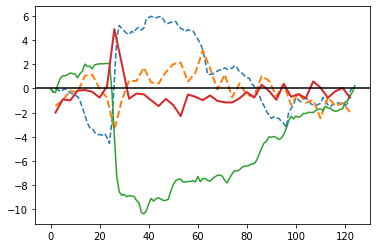

In [143]:
tmp1 = ds_NAO['NAO'].where(NAO_season.isel(time=tim_ind) >= NAO_cut).mean(['start_year','r'])
tmp2 = ds_NAO['NAO'].where(NAO_season.isel(time=tim_ind) <= -NAO_cut).mean(['start_year','r'])

tmp1_psi = (psi_season.where(NAO_season.isel(time=tim_ind) >= NAO_cut).mean(['start_year','r']))
tmp2_psi = (psi_season.where(NAO_season.isel(time=tim_ind) <= -NAO_cut).mean(['start_year','r']))

plt.plot(range(0,125), tmp1.cumsum('time').values - tmp1.values[0], ls='--')
plt.plot(range(2,123,3), 3*tmp1_psi.sel(y= 45., method="nearest"), lw=2, ls='--')
plt.plot(range(0,125), tmp2.cumsum('time').values - tmp2.values[0])
plt.plot(range(2,123,3), 3*tmp2_psi.sel(y= 45., method="nearest"), lw=2)
plt.axhline(y=0, color='k')

(-4.0, 4.0)

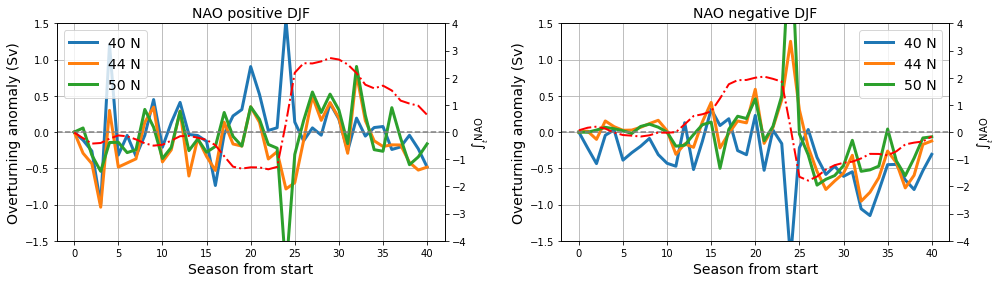

In [163]:
tim_ind = 24

count_NAOp = xr.where(NAO_season.isel(time=tim_ind) >= NAO_cut, 1, 0)
count_NAOn = xr.where(NAO_season.isel(time=tim_ind) <= -NAO_cut, 1, 0)

tmp1 = NAO_season.where(NAO_season.isel(time=tim_ind) >= NAO_cut)
tmp2 = NAO_season.where(NAO_season.isel(time=tim_ind) <= -NAO_cut)

tmp1_psi = (psi_season.where(NAO_season.isel(time=tim_ind) >= NAO_cut))
tmp2_psi = (psi_season.where(NAO_season.isel(time=tim_ind) <= -NAO_cut))

tmp1_psi = tmp1_psi - tmp1_psi.isel(time=0)
tmp2_psi = tmp2_psi - tmp2_psi.isel(time=0)

grid1 = plt.GridSpec(1, 2, wspace=0.3, hspace=0.3)
fig = plt.figure(figsize=[16,4])

col = plt.cm.tab10(np.linspace(0.,0.35,4))

N = count_NAOp.sum().values # 7 days decorrelation time
ci = 1.96 # coefficiet for large N and 95% confidence interval
std_err = (ci/np.sqrt(np.ceil(N)))

ax = fig.add_subplot(grid1[0, 0])

for y in range(2,len(tmp1_psi.y)-2, 1):
    tmp1_std = ((psi_season.sel(y= tmp1_psi['y'].values[y], method="nearest"))
                .where(NAO_season.isel(time=tim_ind) >= NAO_cut).std(['start_year','r']))
    
    ax.plot(range(0,41), tmp1_psi.isel(y=y).mean(['start_year','r']), 
            lw=3., label= str(math.floor(tmp1_psi['y'].values[y])) + ' N')
    #ax.fill_between(range(0,41), (tmp1_psi.isel(y=y).mean(['start_year','r']) - std_err*tmp1_std), 
    #                (tmp1_psi.isel(y=y).mean(['start_year','r']) + std_err*tmp1_std), alpha=0.3)

ax.axhline(y=0, color='grey', ls='--')
ax.legend(fontsize=14)
ax.grid('on')
ax.set_ylim([-1.5, 1.5])
ax.set_ylabel('Overturning anomaly (Sv)', fontsize=14)
ax.set_xlabel('Season from start', fontsize=14)
ax.set_title('NAO positive DJF', fontsize=14)

tmp_cumsum = ((tmp1.mean(['start_year','r'])).cumsum('time')
              - 0.5*tmp1.mean(['start_year','r']))
#tmp1_std = tmp_cumsum.std(['start_year','r'])
ax2=ax.twinx()
ax2.plot(range(0,41), tmp_cumsum, lw=2., ls = '-.', color='red')
#ax2.fill_between(range(0,41), tmp_cumsum.mean(['start_year','r']) - std_err*tmp1_std, 
#                 tmp_cumsum.mean(['start_year','r']) + std_err*tmp1_std, alpha=0.3, color=col[2])
ax2.set_ylabel(r'$\int_t$NAO')
ax2.set_ylim([-4., 4.0])


N = count_NAOn.sum().values # 7 days decorrelation time
ci = 1.96 # coefficiet for large N and 95% confidence interval
std_err = (ci/np.sqrt(np.ceil(N)))

ax = fig.add_subplot(grid1[0, 1])

for y in range(2,len(tmp1_psi.y)-2, 1):
    tmp2_std = ((psi_season.sel(y= tmp1_psi['y'].values[y], method="nearest"))
                .where(NAO_season.isel(time=tim_ind) <= -NAO_cut).std(['start_year','r']))
    
    ax.plot(range(0,41), tmp2_psi.isel(y=y).mean(['start_year','r']), 
            lw=3., label= str(math.floor(tmp2_psi['y'].values[y])) + ' N')
    #ax.fill_between(range(0,41), (tmp1_psi.isel(y=y).mean(['start_year','r']) - std_err*tmp1_std), 
    #                (tmp1_psi.isel(y=y).mean(['start_year','r']) + std_err*tmp1_std), alpha=0.3)

ax.axhline(y=0, color='grey', ls='--')
ax.legend(fontsize=14)
ax.grid('on')
ax.set_ylim([-1.5, 1.5])
ax.set_ylabel('Overturning anomaly (Sv)', fontsize=14)
ax.set_xlabel('Season from start', fontsize=14)
ax.set_title('NAO negative DJF', fontsize=14)

tmp_cumsum = ((tmp2.mean(['start_year','r'])).cumsum('time')
              - 0.5*tmp2.mean(['start_year','r'])) 
    # -0.5*tmp2 is required required to set weight to 0.5 for the last term when we integrate to t0 -> t

#tmp2_std = tmp_cumsum.std(['start_year','r'])
ax2=ax.twinx()
ax2.plot(range(0,41), tmp_cumsum, lw=2., ls = '-.', color='red')
#ax2.fill_between(range(0,41), tmp_cumsum.mean(['start_year','r']) - std_err*tmp1_std, 
#                 tmp_cumsum.mean(['start_year','r']) + std_err*tmp1_std, alpha=0.3, color=col[2])
ax2.set_ylabel(r'$\int_t$NAO')
ax2.set_ylim([-4., 4.0])

In [9]:
HT_season = ds_anom['hfbasin_atlantic'].mean('x')
HT_season = HT_season.assign_coords(y=ds_anom.nav_lat.isel(x=0))
HT_season = HT_season.rename({'time_counter':'time'})
HT_season = HT_season.assign_coords(time=tim)

HT_season = HT_season.sel(y= [30., 35., 40., 45., 50., 55., 60.], method="nearest")

HT_season = (HT_season.isel(time=slice(1,len(HT_season.time)-1)).
             resample(time='QS-DEC').mean('time').compute())


(-4.0, 4.0)

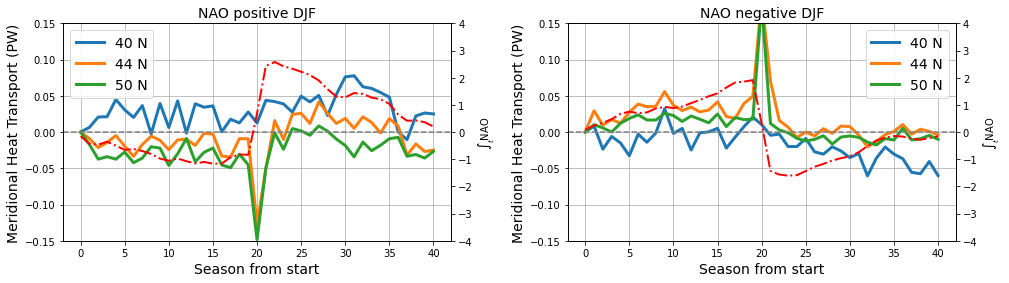

In [11]:
tim_ind = 20

count_NAOp = xr.where(NAO_season.isel(time=tim_ind) >= NAO_cut, 1, 0)
count_NAOn = xr.where(NAO_season.isel(time=tim_ind) <= -NAO_cut, 1, 0)

tmp1 = NAO_season.where(NAO_season.isel(time=tim_ind) >= NAO_cut)
tmp2 = NAO_season.where(NAO_season.isel(time=tim_ind) <= -NAO_cut)

tmp1_HT = (HT_season.where(NAO_season.isel(time=tim_ind) >= NAO_cut))
tmp2_HT = (HT_season.where(NAO_season.isel(time=tim_ind) <= -NAO_cut))

tmp1_HT  = tmp1_HT  - tmp1_HT.isel(time=0)
tmp2_HT  = tmp2_HT  - tmp2_HT.isel(time=0)

grid1 = plt.GridSpec(1, 2, wspace=0.3, hspace=0.3)
fig = plt.figure(figsize=[16,4])

col = plt.cm.tab10(np.linspace(0.,0.35,4))

N = count_NAOp.sum().values # 7 days decorrelation time
ci = 1.96 # coefficiet for large N and 95% confidence interval
std_err = (ci/np.sqrt(np.ceil(N)))

ax = fig.add_subplot(grid1[0, 0])

for y in range(2,len(tmp1_HT.y)-2, 1):

    ax.plot(range(0,41), tmp1_HT.isel(y=y).mean(['start_year','r']), 
            lw=3., label= str(math.floor(tmp1_HT['y'].values[y])) + ' N')

ax.axhline(y=0, color='grey', ls='--')
ax.legend(fontsize=14)
ax.grid('on')
ax.set_ylim([-0.15, 0.15])
ax.set_ylabel('Meridional Heat Transport (PW)', fontsize=14)
ax.set_xlabel('Season from start', fontsize=14)
ax.set_title('NAO positive DJF', fontsize=14)

tmp_cumsum = ((tmp1.mean(['start_year','r'])).cumsum('time')
              - 0.5*tmp1.mean(['start_year','r']))
#tmp1_std = tmp_cumsum.std(['start_year','r'])
ax2=ax.twinx()
ax2.plot(range(0,41), tmp_cumsum, lw=2., ls = '-.', color='red')
#ax2.fill_between(range(0,41), tmp_cumsum.mean(['start_year','r']) - std_err*tmp1_std, 
#                 tmp_cumsum.mean(['start_year','r']) + std_err*tmp1_std, alpha=0.3, color=col[2])
ax2.set_ylabel(r'$\int_t$NAO')
ax2.set_ylim([-4., 4.0])


N = count_NAOn.sum().values # 7 days decorrelation time
ci = 1.96 # coefficiet for large N and 95% confidence interval
std_err = (ci/np.sqrt(np.ceil(N)))

ax = fig.add_subplot(grid1[0, 1])

for y in range(2,len(tmp1_HT.y)-2, 1):

    ax.plot(range(0,41), tmp2_HT.isel(y=y).mean(['start_year','r']), 
            lw=3., label= str(math.floor(tmp2_HT['y'].values[y])) + ' N')

ax.axhline(y=0, color='grey', ls='--')
ax.legend(fontsize=14)
ax.grid('on')
ax.set_ylim([-0.15, 0.15])
ax.set_ylabel('Meridional Heat Transport (PW)', fontsize=14)
ax.set_xlabel('Season from start', fontsize=14)
ax.set_title('NAO negative DJF', fontsize=14)

tmp_cumsum = ((tmp2.mean(['start_year','r'])).cumsum('time')
              - 0.5*tmp2.mean(['start_year','r'])) 
    # -0.5*tmp2 is required required to set weight to 0.5 for the last term when we integrate to t0 -> t

#tmp2_std = tmp_cumsum.std(['start_year','r'])
ax2=ax.twinx()
ax2.plot(range(0,41), tmp_cumsum, lw=2., ls = '-.', color='red')
#ax2.fill_between(range(0,41), tmp_cumsum.mean(['start_year','r']) - std_err*tmp1_std, 
#                 tmp_cumsum.mean(['start_year','r']) + std_err*tmp1_std, alpha=0.3, color=col[2])
ax2.set_ylabel(r'$\int_t$NAO')
ax2.set_ylim([-4., 4.0])

### Contrast Heat Flux Anomalies between Labrador and Irminger

Here, we compare area-avg heat flux monthly anomalies between Labrador and Irminger. The intention is see if both regions tend to have similar signs of anomalies or there are times when these regions behave differently.

In [8]:
ppdir = "/home/users/hkhatri/DePreSys4_Data/Data_Anomaly_Compute/NAO/"

ds_NAO = xr.open_dataset(ppdir + "NAO_SLP_Anomaly.nc")

ppdir = "/home/users/hkhatri/DePreSys4_Data/Data_Anomaly_Compute/"

ds_anom = []

var_list2 = ['hfds', 'tos']

for var in var_list2:
    
    ds = []
    
    for i in range(0,10):
    
        d = xr.open_dataset(ppdir + "Area_mean_timeseries/Anomaly_" + var + "_r" + str(i+1) + ".nc")
        
        ds.append(d)
    
    ds = xr.concat(ds, dim='r')
    
    ds_anom.append(ds)

ds_anom = xr.concat(ds_anom, dim='var')

print(ds_anom, ds_NAO)


<xarray.Dataset>
Dimensions:            (var: 2, r: 10, start_year: 57, time: 125)
Dimensions without coordinates: var, r, start_year, time
Data variables:
    Labrador_Sea       (var, r, start_year, time) float32 -23.22 ... -0.1858
    Irminger_Sea       (var, r, start_year, time) float32 -26.75 ... -0.05278
    Iceland_Basin      (var, r, start_year, time) float32 13.48 ... 0.1332
    North_East_Region  (var, r, start_year, time) float32 7.781 ... 0.7145
    South_West_Region  (var, r, start_year, time) float32 4.255 27.36 ... 0.5047
    South_East_Region  (var, r, start_year, time) float32 18.08 ... 0.05484
    North_Atlantic     (var, r, start_year, time) float32 0.5261 2.21 ... 0.4731 <xarray.Dataset>
Dimensions:     (start_year: 57, r: 10, time: 125)
Coordinates:
  * start_year  (start_year) int64 1960 1961 1962 1963 ... 2013 2014 2015 2016
Dimensions without coordinates: r, time
Data variables:
    NAO         (start_year, r, time) float64 ...
    P_south     (start_year, r, tim

Text(0, 0.5, '$\\mathcal{H}^{\\prime}$ (W/m$^2$) in Irminger')

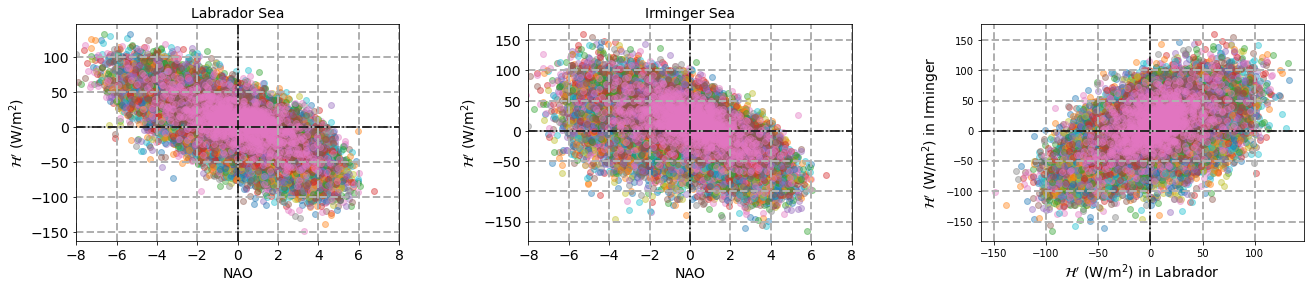

In [22]:
NAO = ds_NAO['NAO']

grid = plt.GridSpec(1, 3, wspace=0.4, hspace=0.4)
fig = plt.figure(figsize=[22,4])

region_list = ['Labrador_Sea', 'Irminger_Sea'] #, 'Iceland_Basin']
tilt_name = ['Labrador Sea', 'Irminger Sea', 'Iceland Basin']

var_list = ['hfds'] #, 'tos']

col = plt.cm.Paired(np.linspace(0.,1., 11))

i =0 
for region in region_list:
    j =0 
    for var in var_list:
        
        ax = fig.add_subplot(grid[j, i])
        
        for start_year in range(0, len(NAO.start_year), 1):
                
            ax.scatter(NAO.isel(start_year=start_year), 
                        ds_anom[region].isel(var = j, start_year=start_year), alpha=0.4)
            ax.grid('on', lw=2, ls='--')
        

        ax.set_ylabel(r'$\mathcal{H}^{\prime}$ (W/m$^2$)', fontsize=14)
        ax.set_xlabel(r'NAO', fontsize=14)
        ax.axhline(y=0.0, color="k", linestyle="-.") 
        ax.axvline(x=0.0, color="k", linestyle="-.") 
        ax.set_xlim([-8., 8.])
        #ax.set_ylim([-120., 120.])
        ax.set_title(tilt_name[i], fontsize=14)
        plt.yticks(fontsize = 14)
        plt.xticks(fontsize = 14)
        
        j = j + 1
    i = i+1
    
ax = fig.add_subplot(grid[0, 2])
for start_year in range(0, len(NAO.start_year), 1):
                
        ax.scatter(ds_anom['Labrador_Sea'].isel(var = 0, start_year=start_year), 
                    ds_anom['Irminger_Sea'].isel(var = 0, start_year=start_year), alpha=0.4)
ax.grid('on', lw=2, ls='--')
ax.axhline(y=0.0, color="k", linestyle="-.") 
ax.axvline(x=0.0, color="k", linestyle="-.")
ax.set_xlabel(r'$\mathcal{H}^{\prime}$ (W/m$^2$) in Labrador', fontsize=14)
ax.set_ylabel(r'$\mathcal{H}^{\prime}$ (W/m$^2$) in Irminger', fontsize=14)